In [1]:
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mp
from mplsoccer.pitch import Pitch, VerticalPitch
import seaborn as sns
import json
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mplsoccer import arrowhead_marker



# We'll only use a vertical pitch for this tutorial
from PIL import Image
import urllib
import json
import os


In [2]:
FILE = "./data/bre-ars.json"

PLAYERS =['Aaron Ramsdale', 'Gabriel Martinelli', 'Gabriel Jesus', 'William Saliba',
         'Albert Sambi Lokonga', 'Granit Xhaka',  'Bukayo Saka', 'FÃ¡bio Vieira', 'Gabriel MagalhÃ£es']

colors = ['#f0a6a1', '#00ff59', '#42fff6', '#ff00ff', '#ff9edd', '#caa8ff', '#0099ff', '#fcff4f', '#ffb694']
# PLAYER_ID = 394924
ASSIST_ID = [92,47,48,49,50,51,52]
KEY_PASS = [39,40,41,42,43,44,45,46]
THROW_IN = [212]

In [3]:
with open(FILE) as f:
    d = json.load(f)

In [4]:
def retrieve_init(name):
    words = name.split()
    initials = ""
    if len(words) ==1:
        initials=words[0]
    else:
        for word in words:
            initials += word[0]
    return initials

player_dict = dict(d['matchCentreData']['playerIdNameDictionary'])

player_data = [(x, player_dict[x]) for x in player_dict]
player_data = pd.DataFrame(player_data, columns=['playerId', 'player_name'])
player_data['playerId'] = player_data['playerId'].astype('int64')


player_data['initials'] = player_data['player_name'].apply(lambda x: retrieve_init(x))

In [5]:
def throw_in(df):
    throw = pd.DataFrame()
    for index, row in df.iterrows():
        if any(elem in row.loc["satisfiedEventsTypes"] for elem in THROW_IN):
            throw = throw.append(row)
    return throw

In [6]:
passing_data = [x for x in d['matchCentreData']['events'] if x['type']['displayName'] == 'Pass']

passing_data = pd.json_normalize(passing_data)
passing_data = passing_data.drop(['isTouch', 'type.value','period.value','outcomeType.value', 'id'], axis =1)
passing_data = pd.merge(passing_data, player_data, on=['playerId'])

throw_in_data =throw_in(passing_data)
passing_data = passing_data.drop(throw_in_data.index)

C:\Users\jawah\AppData\Local\Temp\ipykernel_6804\636337300.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  throw = throw.append(row)
C:\Users\jawah\AppData\Local\Temp\ipykernel_6804\636337300.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  throw = throw.append(row)
C:\Users\jawah\AppData\Local\Temp\ipykernel_6804\636337300.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  throw = throw.append(row)
C:\Users\jawah\AppData\Local\Temp\ipykernel_6804\636337300.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  throw = throw.append(row)
C:\Users\jawah\AppData\Local\Temp\ipykernel_6804\636337300.py:5: FutureWarning: The frame.append

In [8]:
# PLAYER_ID = passing_data[passing_data.player_name == PLAYER_NAME]['playerId'].iloc[1]
# player_passes = passing_data.loc[passing_data.player_name == PLAYER_NAME, ['x', 'y', 'endX', 'endY', 'period.displayName',
#                                                                           'outcomeType.displayName', 'satisfiedEventsTypes']]

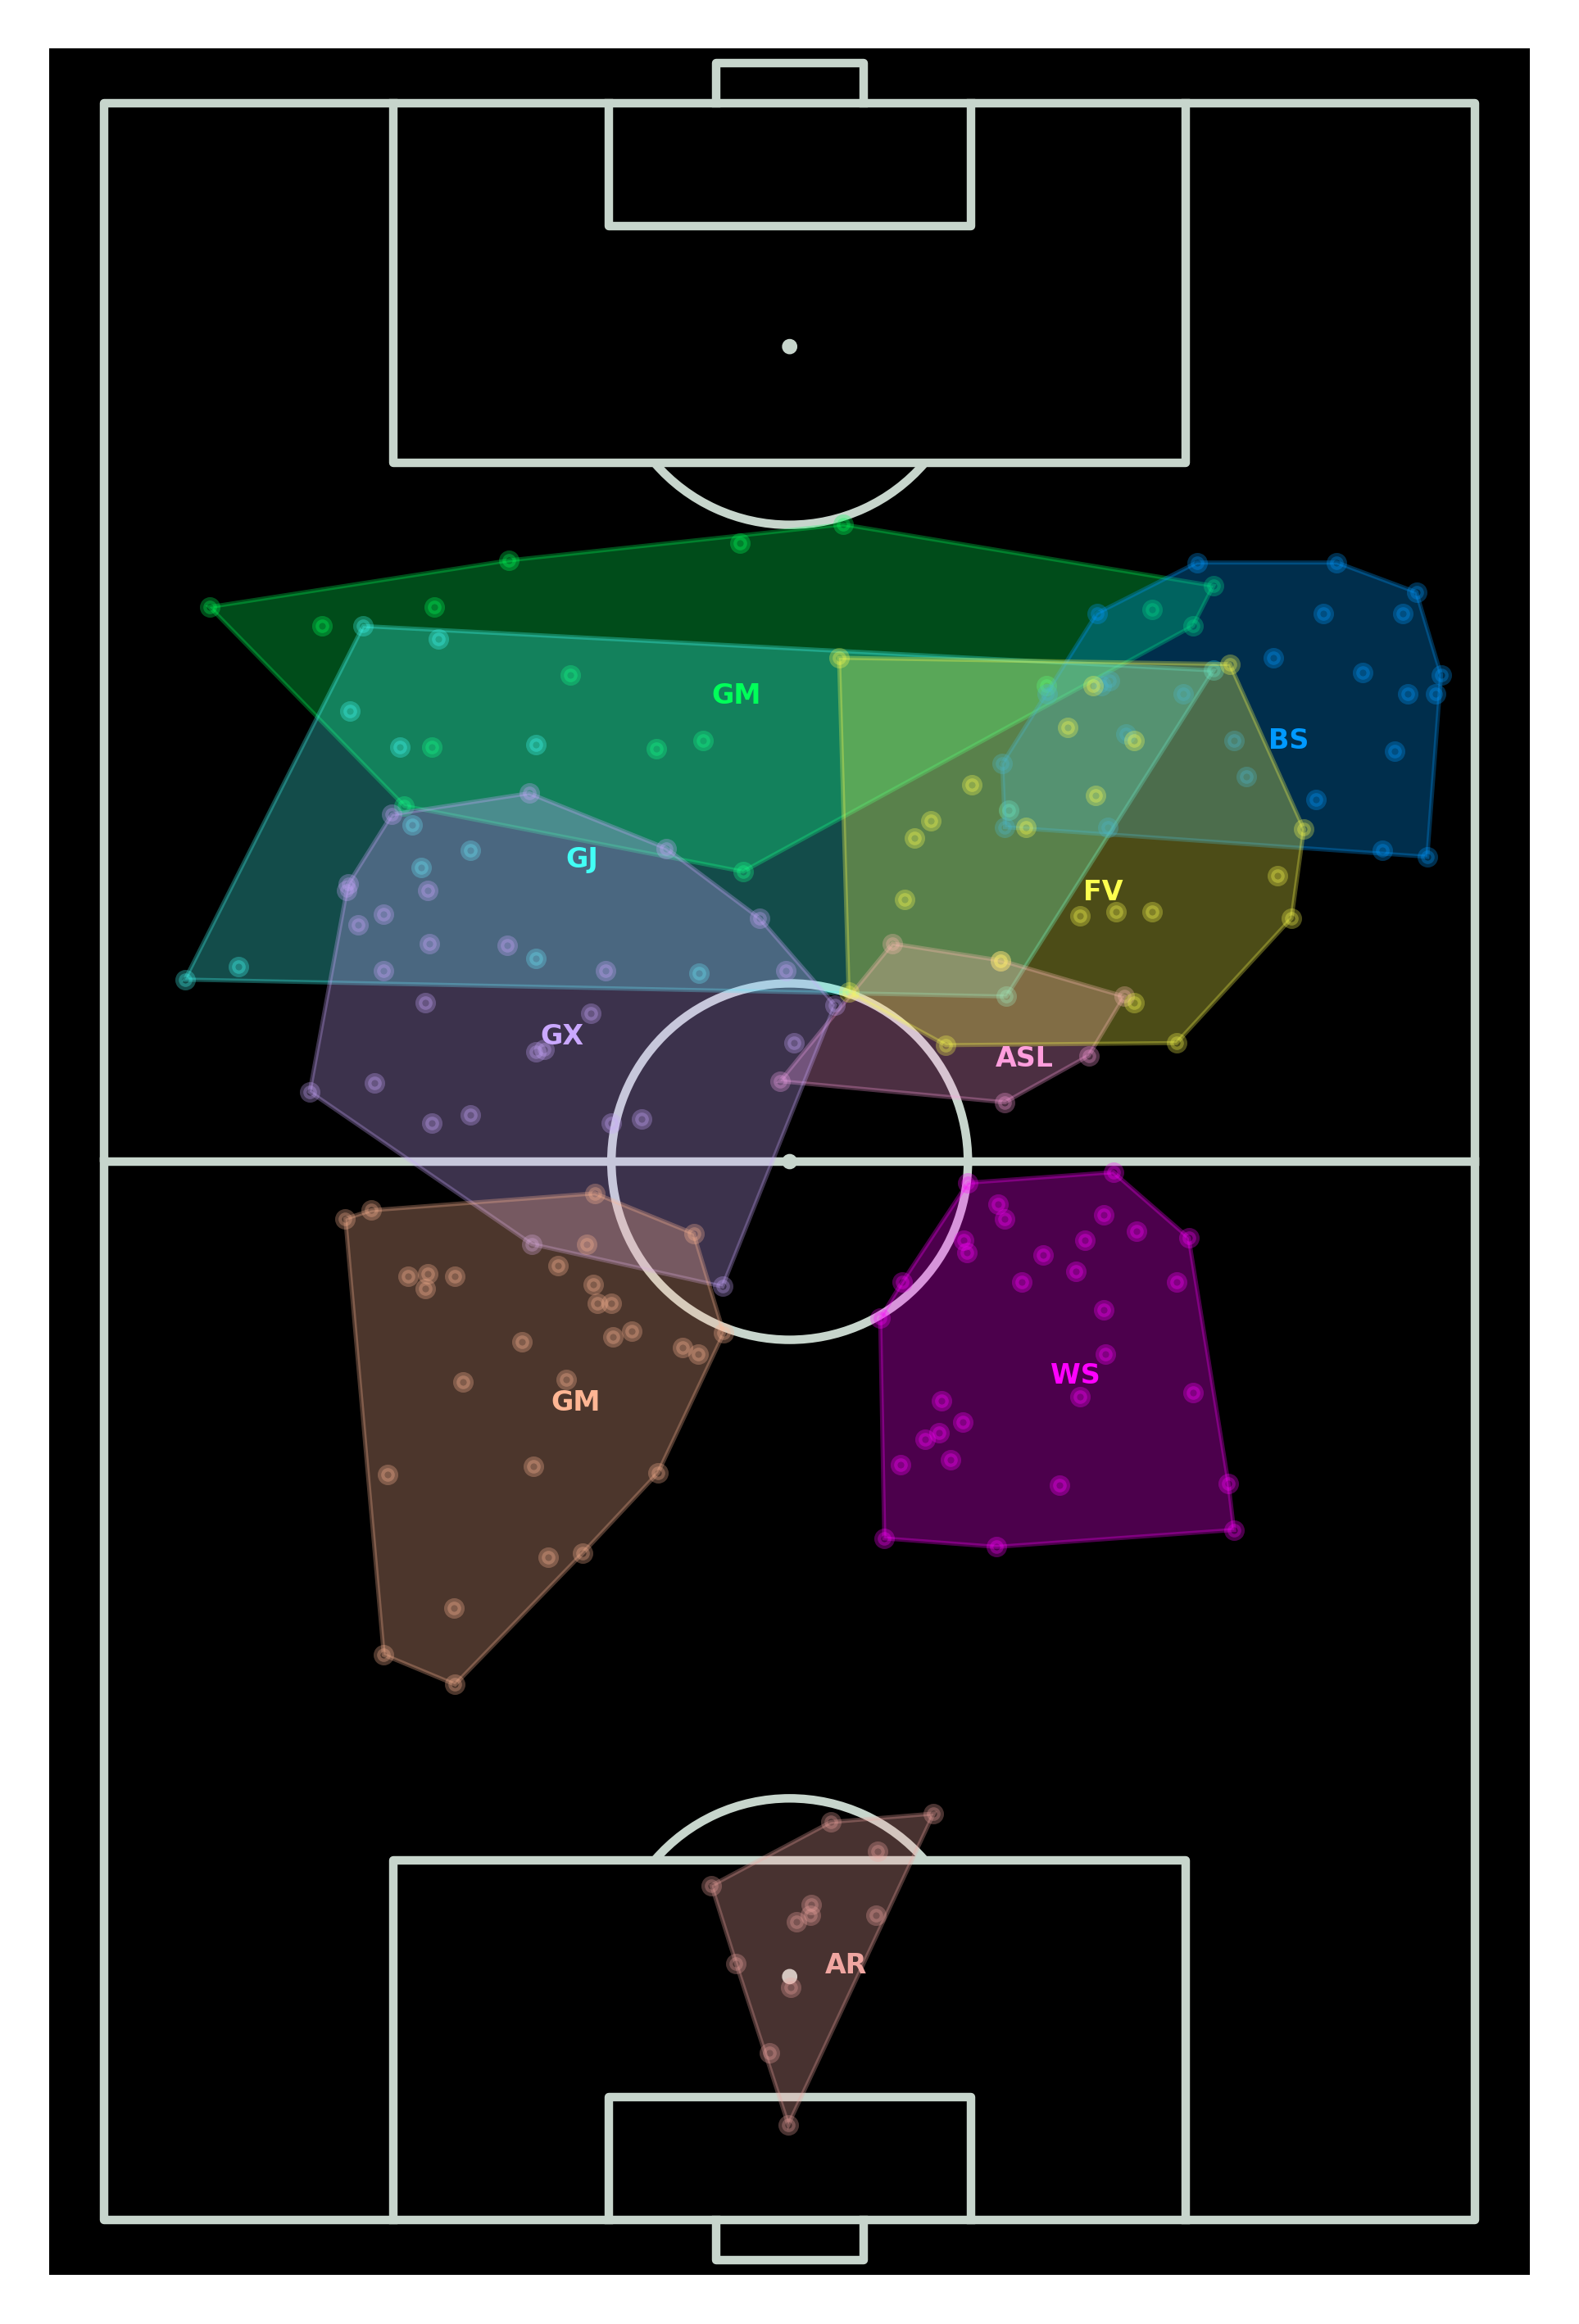

In [26]:
fig = plt.figure(figsize = (8,6), dpi = 600)
ax = plt.subplot(111)

pitch = VerticalPitch(
    pitch_type='opta',
    goal_type='box',
    linewidth=1.25,
    pitch_color='black', 
    line_color='#c7d5cc'
)

pitch.draw(ax = ax)

for idx, player in enumerate(PLAYERS):
    PLAYER_ID = passing_data[passing_data.player_name == player]['playerId'].iloc[1]
    initials = passing_data[passing_data.player_name == player]['initials'].iloc[1]
    player_passes = passing_data.loc[passing_data.player_name == player, ['x', 'y', 'endX', 'endY', 'period.displayName',
                                                                          'outcomeType.displayName', 'satisfiedEventsTypes']]
    pass_filter_x = player_passes['x'].quantile([.2, .8]).values
    pass_filter_y = player_passes['y'].quantile([.1, .9]).values
    player_passes = player_passes[(player_passes['x'].between(pass_filter_x[0], pass_filter_x[1])) &
                                 (player_passes['y'].between(pass_filter_y[0], pass_filter_y[1]))]    
    hull = pitch.convexhull(player_passes.x, player_passes.y)
    poly = pitch.polygon(hull, ax=ax, edgecolor=colors[idx], facecolor=colors[idx], alpha=0.3,
                        linewidth=0.6)
#     ax_text(
#         x=player_passes['y'].mean(), y=player_passes['x'].mean(),
#         s=f"{player}",
#         ax=ax,
#         color=colors[idx],
#         size=3,
#         font='DM Sans',
#         ha='left'
#     )
    ax_text(
        x=player_passes['y'].mean()-1, y=player_passes['x'].mean()-1,
        s=f"{initials}",
        ax=ax,
        color=colors[idx],
        size=4,
        font='DM Sans',
        ha='left'
    )
    scatter = pitch.scatter(player_passes.x, player_passes.y, ax=ax, edgecolor=colors[idx], facecolor=colors[idx],
                            s=4, alpha=0.3)
    x = player_passes['y'].mean()
    y = player_passes['x'].mean()
#     poly = np.array([[x-3,y-3],[x-3,y+2],[x+3,y+2],[x+3,y-3]])

#     p = Polygon(poly, facecolor = colors[idx], alpha =0.8)
#     ax.add_patch(p)

plt.show()

fig.savefig("viz/Hull- %s.png"%(d['matchId']), dpi=600, bbox_inches='tight', pad_inches=0.,
           facecolor = "#f4f5dc")